In [15]:
# Import Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
from torch.utils.data import Dataset


from scipy.ndimage import rotate
# from pretrained_models.resnet20 import ResNetCIFAR
# load Imagenet dataset
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import os
from functions import *
from importlib import reload

import pandas as pd

reload(sys.modules["functions"])

<module 'functions' from '/workspaces/Adversarial-Patches-Experimentation/10_code/functions.py'>

## Prepare Data

# Kaggle Imagenet-mini

In [ ]:
# kaggle datasets download <USER_NAME>/<DATASET_NAME>

In [26]:
# https://www.kaggle.com/code/stpeteishii/imagenet-mini-1000-torch-alexnet
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/workspaces/Adversarial-Patches-Experimentation/00_data/imagenet-mini/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            labels+=[label]
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('/workspaces/Adversarial-Patches-Experimentation/00_data/imagenet-mini/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]   
class_names=sorted(set(labels))
#print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))   
df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
df['label']=df['label'].map(normal_mapping)

tdf=pd.DataFrame(columns=['path','label'])
tdf['path']=tpaths
tdf['label']=tlabels
tdf['label']=tdf['label'].map(normal_mapping)

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        path = self.dataframe.loc[index, 'path']
        label = self.dataframe.loc[index, 'label']
        image = Image.open(path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            ])
        image = transform(image)
        return image, label

train_ds=CustomDataset(df)
test_ds=CustomDataset(tdf)

train_set, val_set = torch.utils.data.random_split(train_ds, [0.9, 0.1])

train_loader=DataLoader(train_set,batch_size=32,shuffle=True, num_workers= 4)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
test_loader=DataLoader(test_ds,batch_size=32, num_workers= 4)


1000


4294    AxesImage(shape=(212, 165, 3))
Name: path, dtype: object

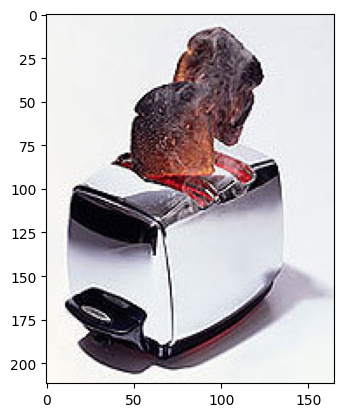

In [27]:
# plot the first row of image from path, label = 859, check if its toaster
df[df.label == 859].head(1).path.apply(lambda x: plt.imshow(Image.open(x).convert('RGB')))

## Run the Model with the Patch Attack

In [18]:
# load the Pre-Trained ResNet-18 model
net = models.resnet18(pretrained=True)


/home/codespace/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Circle Patch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
p, x = patch_attack_targeted(net, device, train_loader, val_loader, target_class=859, patch_size=64, patch_type="circle", num_epochs=1)

### Square Patch

In [6]:
p_sq, x_sq = patch_attack_targeted(net, device, train_loader, val_loader, target_class=1, patch_size=16, patch_type="square", num_epochs=20)

Epoch 0, Attack Success Rate: 0.6897194981575012.


Epoch 5, Attack Success Rate: 0.931259036064148.


Epoch 10, Attack Success Rate: 0.940971851348877.


Epoch 15, Attack Success Rate: 0.948458194732666.


# previous prepare data code

In [ ]:
# PARAMS
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# target = 1  # automobile

# Imagenet image tensor mean and std
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
# TODO: should we apply the below transformations?
# Define the transform to preprocess the images
transform_train = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),
])

transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)]
)

transform_image = transforms.ToPILImage()

# imagenet_data = torchvision.datasets.ImageNet('../00_data')


print("==> Preparing data..")
trainset = torchvision.datasets.ImageNet(
    root="/workspaces/Adversarial-Patches-Experimentation/00_code_test", split = 'train', download=True, transform=transform_train
)
# trainloader = torch.utils.data.DataLoader(
    # trainset, batch_size=batch_size, shuffle=True, num_workers=4
# )

# testset = torchvision.datasets.ImageNet(
#     root="../00_data", train=False, download=True, transform=transform_test
# )
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2
# )